
# ***Librairies***

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

# **Lines Detection**

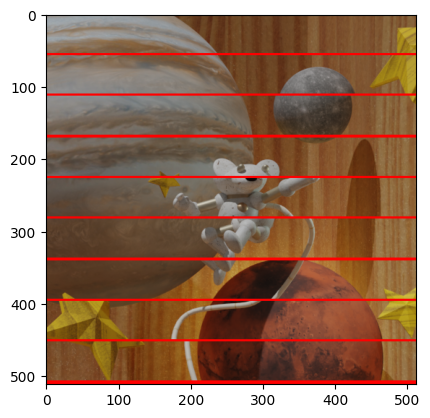

In [15]:
image = cv2.imread('1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
f, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY_INV)
contours, f = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)

# Hough transform
lines = cv2.HoughLinesP(binary, 1, np.pi / 180, 10, minLineLength=100, maxLineGap=10)


if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.show()
plt.imsave('divperiode.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# **Getting the image segments**

Positions des segments dans l'image 88.png : [(0, 55), (55, 111), (111, 168), (168, 169), (169, 225), (225, 281), (281, 338), (338, 339), (339, 395), (395, 451), (451, 508), (508, 509), (509, 510), (510, 511), (511, 512)]


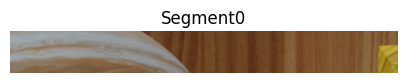

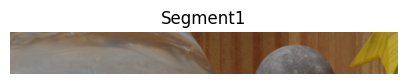

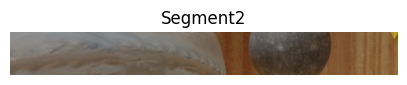

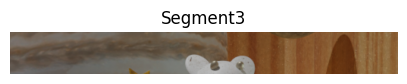

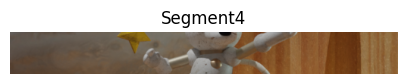

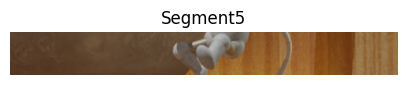

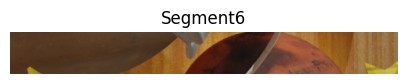

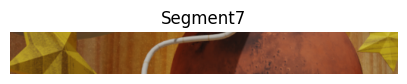

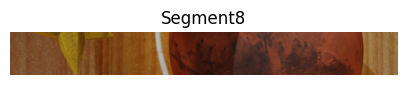

In [21]:
def segment_and_save_image(image_path, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    image = cv2.imread('1.png')

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)     # Seuillage pour obtenir une image binaire

    # lignes avec la transformation de Hough
    lines = cv2.HoughLinesP(binary, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
    lines_coords = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            lines_coords.append((x1, y1, x2, y2))    # dessiner et stocker les coordonnées
            #cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 1)

    lines_coords.sort(key=lambda x: min(x[1], x[3]))  # Tri des coordonnées des lignes par leur position y pour découper l'image horizontalement

    # Découpage de l'image
    segments = []
    prev_y = 0
    positions = []
    for idx, (x1, y1, x2, y2) in enumerate(lines_coords):
        y = min(y1, y2)
        segment = image[prev_y:y, :]
        positions.append((prev_y, y))
        if segment.size > 0:
            segment_path = os.path.join(output_directory, f'segment_{idx}.png')
            cv2.imwrite(segment_path, segment)
            segments.append(segment)
        prev_y = y

        last_segment = image[prev_y:, :]     # Ajout du dernier segment après la dernière ligne détectée

    if last_segment.size > 0:
      segment_path = os.path.join(output_directory, f'segment_{len(lines_coords)}.png')
      cv2.imwrite(segment_path, last_segment)
      segments.append(last_segment)
      positions.append((prev_y, image.shape[0]))

    return segments, positions

segments, positions = segment_and_save_image(input_image_path, output_directory)

print("Positions des segments dans l'image 88.png :", positions)

def remove_thin_segments(segments, min_thickness):

  thick_segments = []
  for segment in segments:
    height, width, _ = segment.shape
    if height >= min_thickness:
      thick_segments.append(segment)

  return thick_segments


thick_segments = remove_thin_segments(segments, 2)

for i, segment in enumerate(thick_segments):
  plt.figure(figsize=(5, 5))
  plt.imshow(cv2.cvtColor(segment, cv2.COLOR_BGR2RGB))
  plt.title(f'Segment{i}')
  plt.axis('off')
  plt.show()




# **Generation of new images**

Positions des segments dans l'image 1.png : [(0, 55), (55, 111), (111, 168), (168, 169), (169, 225), (225, 281), (281, 338), (338, 339), (339, 395), (395, 451), (451, 508), (508, 509), (509, 510), (510, 511), (511, 512)]


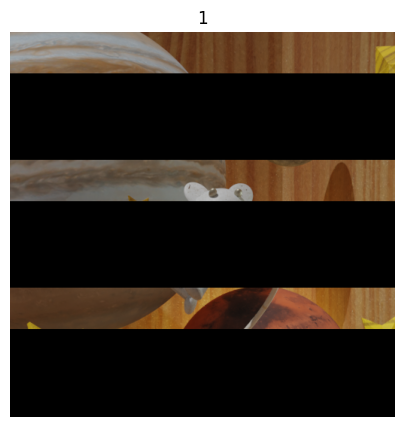

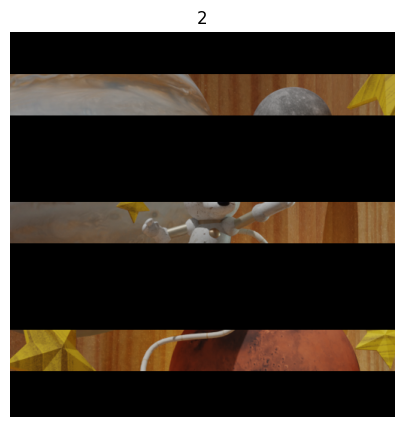

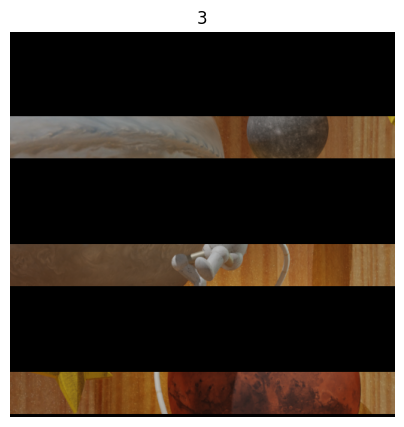

In [22]:
def segment_and_save_image(image_path, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    image = cv2.imread(image_path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)  # Seuillage pour obtenir une image binaire

    # transformation de Hough
    lines = cv2.HoughLinesP(binary, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)

    lines_coords = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            lines_coords.append((x1, y1, x2, y2))  # Stocker coordonnées

    lines_coords.sort(key=lambda x: min(x[1], x[3]))  # Tri des coordonnées des lignes par leur position y

    # Découpage de l'image
    segments = []
    prev_y = 0
    positions = []
    for idx, (x1, y1, x2, y2) in enumerate(lines_coords):
        y = min(y1, y2)
        segment = image[prev_y:y, :]
        positions.append((prev_y, y))
        if segment.size > 0:
            segment_path = os.path.join(output_directory, f'segment_{idx}.png')
            cv2.imwrite(segment_path, segment)
            segments.append(segment)
        prev_y = y


    last_segment = image[prev_y:, :]
    if last_segment.size > 0:
        segment_path = os.path.join(output_directory, f'segment_{len(lines_coords)}.png')
        cv2.imwrite(segment_path, last_segment)
        segments.append(last_segment)
        positions.append((prev_y, image.shape[0]))

    return segments, positions

def remove_thin_segments(segments, positions, min_thickness):
    thick_segments = []
    thick_positions = []
    for segment, position in zip(segments, positions):
        height, width, _ = segment.shape
        if height >= min_thickness:
            thick_segments.append(segment)
            thick_positions.append(position)
    return thick_segments, thick_positions

def fill_matrices(segments, positions, nbre_matrices, matrix_height=512, matrix_width=512):
    matrices = [np.zeros((matrix_height, matrix_width, 3), dtype=np.uint8) for _ in range(nbre_matrices)]

    for i in range(nbre_matrices):
        for j in range(len(segments)):
            if j % nbre_matrices == i:
                segment = segments[j]
                y_start, y_end = positions[j]
                segment_height = y_end - y_start
                matrices[i][y_start:y_start + segment_height, :segment.shape[1]] = segment

    return matrices

input_image_path = '1.png'
output_directory = 'output_segments'

segments, positions = segment_and_save_image(input_image_path, output_directory)
print("Positions des segments dans l'image 1.png :", positions)

thick_segments, thick_positions = remove_thin_segments(segments, positions, 2)


nbre_matrices = 3
matrices = fill_matrices(thick_segments, thick_positions, nbre_matrices)

for i, matrix in enumerate(matrices):
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(matrix, cv2.COLOR_BGR2RGB))
    plt.title(f'{i+1}')
    plt.axis('off')
    plt.show()